In [7]:
import pickle #save model

import pandas as pd
import numpy as np
from scipy import stats #import to calculate Standard error of Kfold results

import matplotlib.pyplot as plt
import seaborn as sns # For visualisations

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings('ignore')

In [8]:
#import the full, labelled data set
pots = pd.read_csv('../../Pots_clean.csv')
pots.head(1)

,productcode,decoration,depth,description,firing,height,maker,materials,name,price,technique,width
0,AM470Y165,Glaze,22.0,this stoneware bowl is wheel-thrown with a cre...,Electric,8.0,Andy Mason,Stoneware,ovalled bowl cream satin motif,47.0,Thrown,25.5


In [9]:
pots_encoded = pd.get_dummies(
                                pots.drop(columns=['productcode', 'name', 'maker', 'description']),
                                drop_first=True #Always drop one category as information is encoded in subsequent vars
                            )

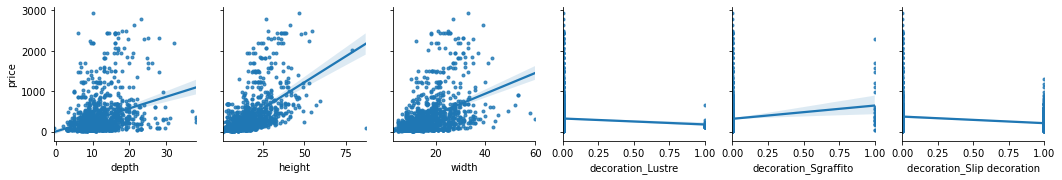

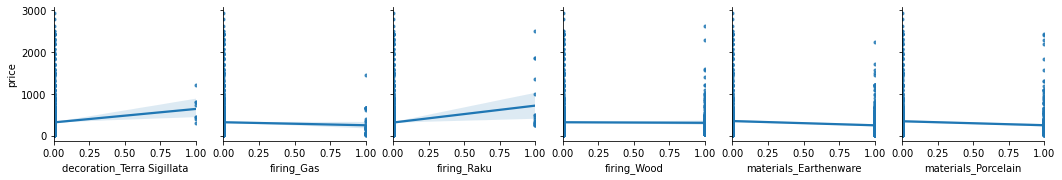

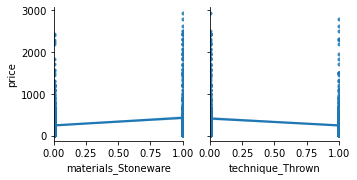

In [10]:
cols = pots_encoded.columns.drop('price')
n_cols = 6

for i in range(0, len(cols), n_cols):
    sns.pairplot(data=pots_encoded[pots_encoded['price'] < 3000], #exclude most expensive pots for visual purposes
             x_vars=cols[i:i+n_cols], 
             y_vars=['price'],
             markers='.',
             diag_kind=None, #needed to avoid broken pairplot logic (as of version 0.11.1)
             kind='reg')
    plt.show()

<AxesSubplot:>

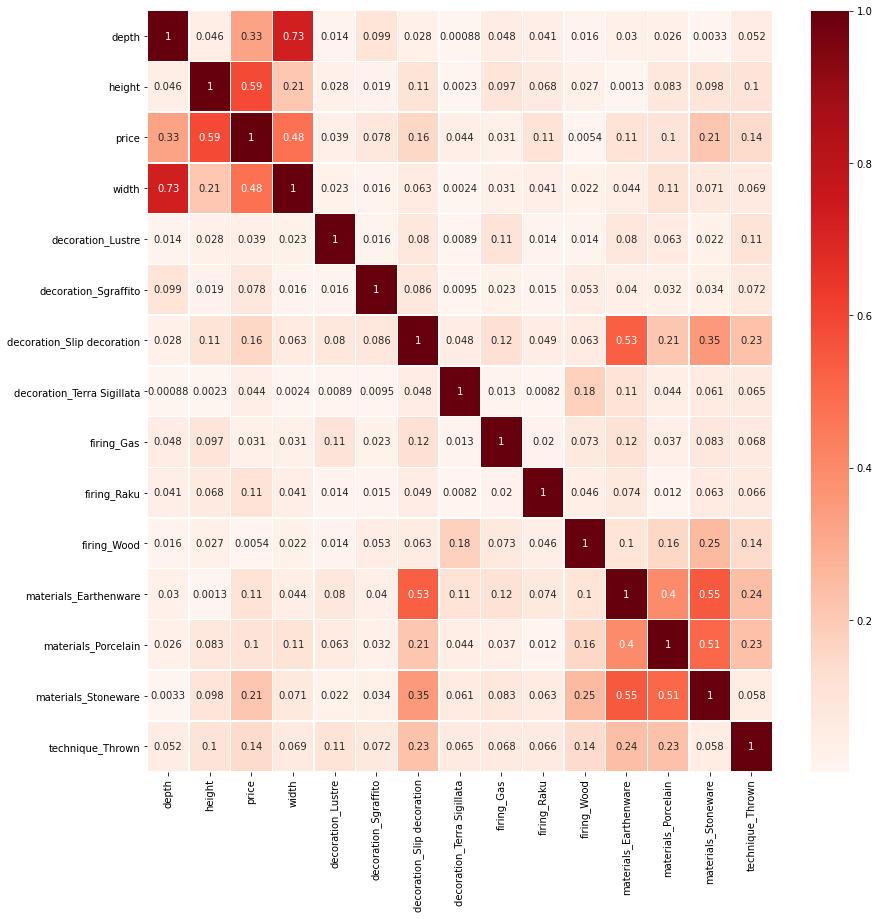

In [11]:
plt.figure(figsize=(14, 14))
sns.heatmap(abs(pots_encoded.corr()), annot = True, linewidths = 0.5, cmap = 'Reds')

There are two correlation clusters to take care of:
1. Width, depth
2. materials_Earthenware, materials_Porcelain, materials_Stoneware

Let's use the mean of width and depth and call it 'length'

In [12]:
pots_reg = pots_encoded.copy()

pots_reg['length'] = pots_reg[['depth', 'width']].mean(axis=1)
pots_reg.drop(columns=['depth', 'width'], inplace = True)

In [13]:
pots_reg[pots_reg['price']<=1000].shape

(1403, 14)

In [14]:
pots_reg = pots_reg[pots_reg['price']<=1000]

In [15]:
pots_reg = pots_reg.reset_index()

I will deal with the multicollinearity of the materials categorical variables using a regularized approach, if need be.

Before going ahead with the regression, let's look at the dependent value (price).

<AxesSubplot:xlabel='price', ylabel='Count'>

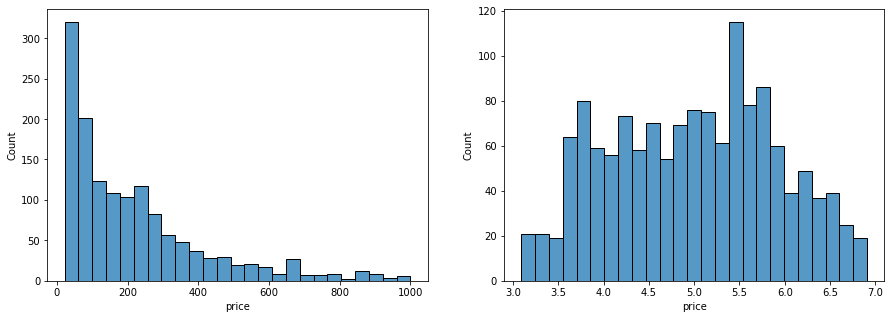

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.histplot(pots_reg['price'], ax=ax[0], bins = 25)
sns.histplot(np.log(pots_reg['price']), ax=ax[1], bins=25)

Early indications already show that the dependent variable is not well distributed, and may quickly end up violating the linearity theorem. 

This will be investigated below where we'll firstly apply OLS to the raw dataset without any transformations.

# Regressor function

Regressor functions to inspect a series of regressions *without* a log transformation to redistribute the mean and variance of the price dependent variable

In [17]:
# regression function that returns predictions by firstly splitting into train/test
def regressor(X, y, regression_class):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    lin_reg = regression_class
    lin_reg.fit(X_train, y_train)

    preds_train = lin_reg.predict(X_train)
    preds_test = lin_reg.predict(X_test)
    preds_all = lin_reg.predict(X)
    residuals = y - preds_all
    
    return X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals

# calculate regression error metrics
def reg_errors(y, preds):
    
    mae = mean_absolute_error(y, preds)
    rmse = mean_squared_error(y, preds, squared=False)
    r2 = r2_score(y, preds)
    
    return mae, rmse, r2

#plot of regression and it's assumptions.
def reg_plots(func, string_description): #func argument to be any OLS function from sklearn (Linear regression, Lasso..)
    
    #call regression function
    X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals = func

    #call errors function
    mae_train, rmse_train, r2_train = reg_errors(y_test, preds_test)
    mae_test, rmse_test, r2 = reg_errors(y_train, preds_train)
    
    fig, axes = plt.subplots(1,3,figsize=(15,6))

    #Generate a plot title with errors
    fig.suptitle("Regression: {}\n \
                 MAE = £{}\n \
                 RMSE = £{} \n \
                 R2 = {}".format(string_description, round(mae_test, 1), round(rmse_test, 1), round(r2,3)))

    # check assumtion: distrubtion of residuals
    sns.histplot(residuals, kde = True, bins = 100, ax=axes[0])
    axes[0].set_title("Distribution of residuals (= y - predicted)")

    #further inspection of distribution of residuals
    qqplot(residuals, line='45', fit=True, ax=axes[1])
    axes[1].set_title("Q-Q plot")

    #Inspect homoscedasticity and independence of variables
    sns.scatterplot(x=preds_all, y=residuals, ax=axes[2], alpha = 0.5, s=25)
    plt.hlines(0, min(preds_all), max(preds_all), linestyles='dashed', colors='red')
    axes[2].set_xlabel("predicted price")
    axes[2].set_ylabel("residuals")
    axes[2].set_title("residuals vs price predicted")
    
    plt.tight_layout()

## Simple linear regression

On inspection of the pairplot I can quickly assume that height is probably the main contributing factor to the price of a pot. This follows intuitively simply from the fact that a larger object is more expensive - it takes more time to make, more resources and requires more energy to fire in a kiln as it takes more space than a smaller pot.

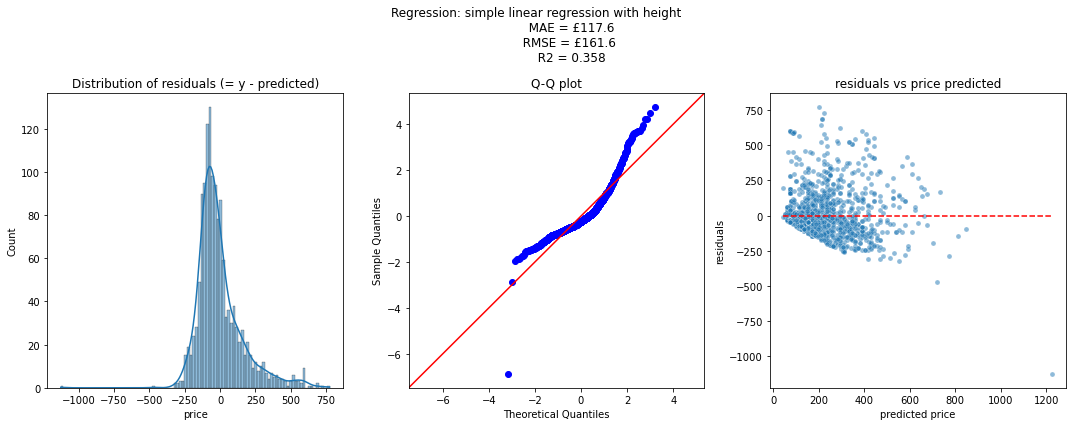

In [18]:
X = pots_reg[['height']]
y = pots_reg['price']

reg_plots(regressor(X, y, LinearRegression()), 'simple linear regression with height')

Early indications:

1. non noramlly distributed residuals. A worrying tail towards large prices exists. This is reinforced in the QQ plot.
2. Strong heteroscedasticity with autocorrelation evident in the price predictions, based on residuals.

## Multiple linear regressions

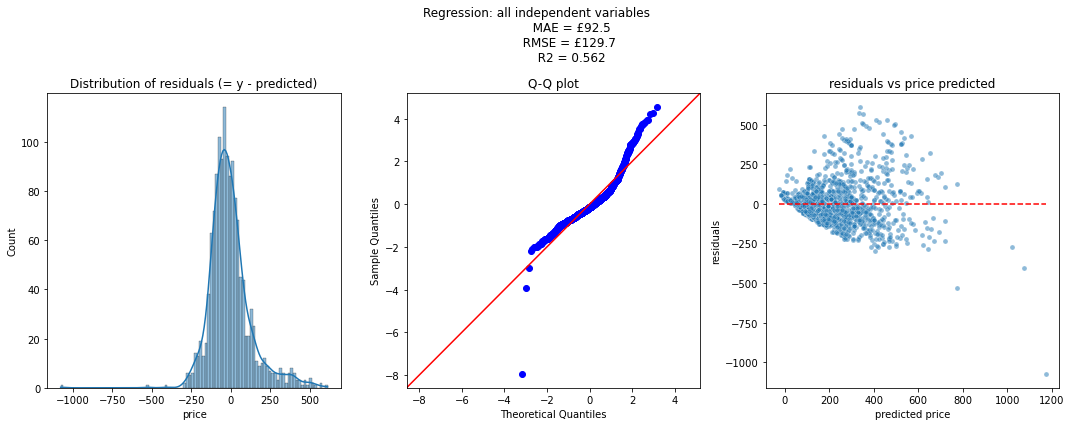

In [19]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']] #all independent variables
y = pots_reg['price']

reg_plots(regressor(X, y, LinearRegression()), 'all independent variables')

# Log transformation dependent variable

Having inspected the distribution of the dependent variable I can safely start to think that the violation of assumptions occuring above is due in part to the poorly distributed dependent variable.

Here I will carry out the above but with log transformed dependent variable.

Firstly, here are some functions to handle the log transformation regressions. Similar to the above but with some extras added to allow some more thorough analysis.

In [20]:
#define a regression function that calls any of sklearn's OLS regressors (LinearRegression, Lasso...)
def log_regressor(X, y, regression_class):
    
    y=np.log(y) #take the natural logarithm of the dependent variable.
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 123)

    lin_reg = regression_class
    lin_reg.fit(X_train, y_train)
    
    intercept = lin_reg.intercept_
    coefficients = dict(zip(X.columns, lin_reg.coef_)) #zip coefficients into a dictionary with variable names.

    preds_train = lin_reg.predict(X_train)
    preds_test = lin_reg.predict(X_test)
    preds_all = lin_reg.predict(X)
    residuals = y - preds_all
    
    return X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals, coefficients, intercept

# calculate regression errors with exponential function included to return log(prices) back to the original space.
def log_reg_errors(y, preds):
    
    mae = mean_absolute_error(np.exp(y), np.exp(preds))
    rmse = mean_squared_error(np.exp(y), np.exp(preds), squared=False)
    r2 = r2_score(y, preds)
    
    return mae, rmse, r2

#plot of regression and it's assumptions.
# func argument can be the regressor function, or any other function. log_regressor and lasso_regressor are others.
def log_reg_plots(func, string_description, plot_bool):
    
    X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals, coefficients, intercept = func

    mae_train, rmse_train, r2_train = log_reg_errors(y_train, preds_train)
    mae_test, rmse_test, r2_test = log_reg_errors(y_test, preds_test)
    
    if plot_bool == True:
    
        fig, axes = plt.subplots(1,3,figsize=(15,6))

        fig.suptitle("Regression: {}\n \
                     MAE = £{} \n \
                     RMSE = £{} \n \
                     R2 = {}".format(string_description, 
                                     round(mae_test, 1), 
                                     round(rmse_test, 1),
                                     round(r2_test,3)
                                    ))

        sns.histplot(residuals, kde = True, bins = 100, ax=axes[0])
        axes[0].set_title("Distribution of log(residuals)")

        qqplot(residuals, line='45', fit=True, ax=axes[1])
        axes[1].set_title("Q-Q plot")

        sns.scatterplot(x=preds_all, y=residuals, ax=axes[2], alpha = 0.5, s=15)
        plt.hlines(0, min(preds_all), max(preds_all), linestyles='dashed', colors='red')
        axes[2].set_xlabel("predicted price")
        axes[2].set_ylabel("residuals")
        axes[2].set_title("residuals vs price predicted")

        plt.tight_layout()
    
    return coefficients, intercept

## Simple linear regression

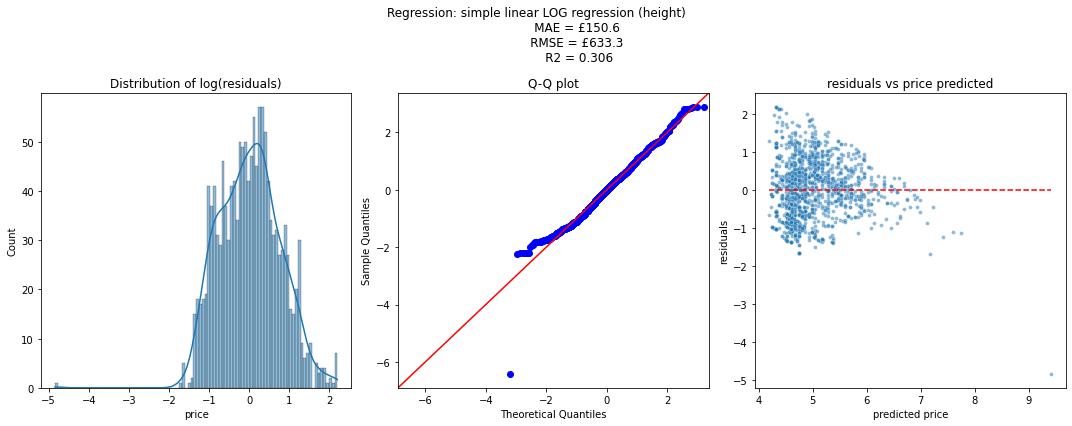

In [21]:
X = pots_reg[['height']]
y = pots_reg['price']

coefficients, intercept = log_reg_plots(log_regressor(X, y, LinearRegression()), 
                                        'simple linear LOG regression (height)', 
                                        True
                                       )

It is immediately obvious that the assumptions are behaving far better and on first impressions the model is able to explain far more variance in the test dataset as well as decreasing the errors to a manageable amount.

RMSE, however, is prone to quite large outliers, and from original price distribution I know that an RMSE of ~1400 is indicating that the regression is not generalising well to the prices in the dataset.

I can go ahead and improve my model using:

1. multiple linear regression
2. multiple linear regression with polynomials of order=2.

## Multiple linear regression

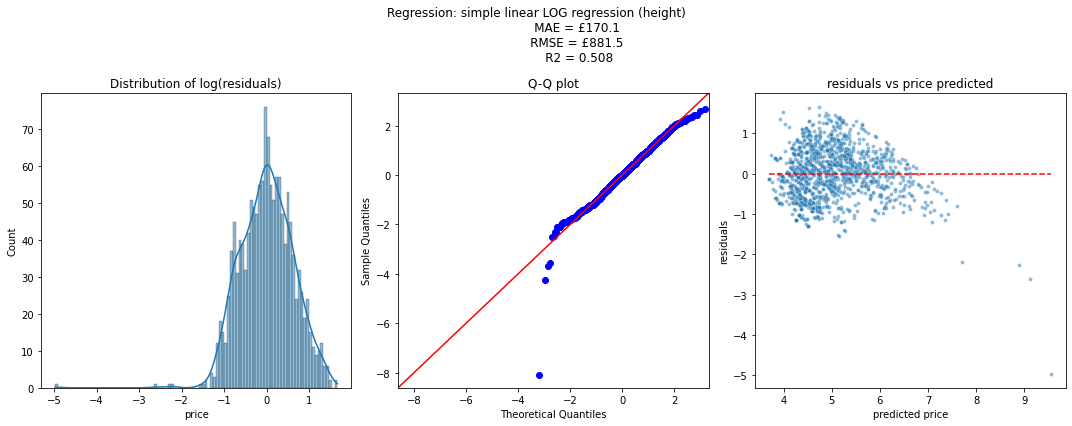

In [22]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

coefficients, intercept = log_reg_plots(log_regressor(X, y, LinearRegression()),
                                        'simple linear LOG regression (height)',
                                        True
                                       )

There is still quite a large error in the RMSE and the MAE has only marginally improved from ~300 to ~220. 

Additionally, there is still some misbehaviour in the core linear regression assumptions.

## Multiple regression, polynomial order = 2

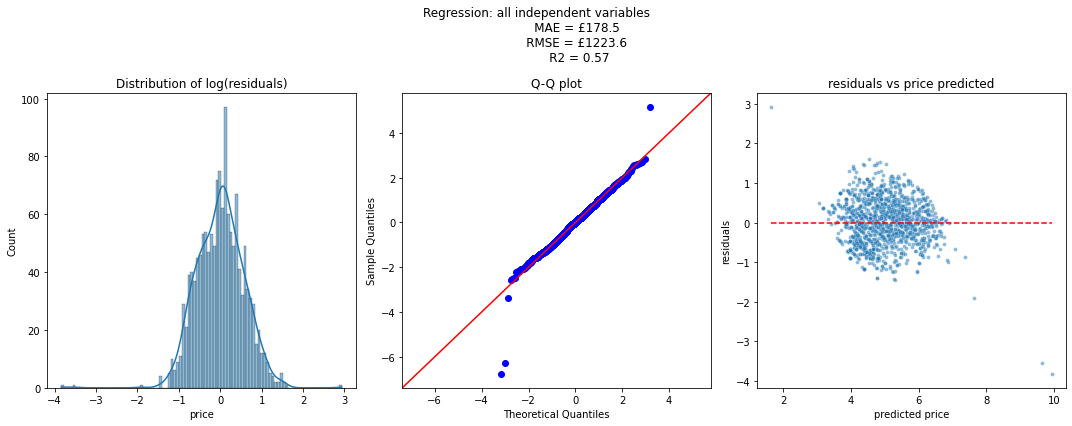

In [23]:
X_ = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

# Define a PolynomialFeatures transformer with degree=2 and include_bias=False, and fit.
poly = PolynomialFeatures(degree=2, include_bias=False)
X = poly.fit_transform(X_)

# Reinsert back into a dataframe
X = pd.DataFrame(data=X, columns=poly.get_feature_names())

coefficients, intercept = log_reg_plots(log_regressor(X, y, LinearRegression()),
                                        'all independent variables', 
                                        True
                                       )

At 104 features, this is now starting to resemble a black box predictor with difficulty in interpretability.

However, I have a drastic improcevement in all the assumptions. Given the range of prices that are seen in this dataset of ~1200 pots, an MAE of ~160 is quite appropriate. Additionally, this model is able to explain a fair amount of variance at r^2 = 71%. Having said that I shan't rely too much on the meaning of that, as wide variance in the price can cause the r^2 value to drop significantly. 

In an attempt to improve explainability, note that it is easily possible create a Lasso regressor here with automated crossvalidation (CV) using sklearn's very own LassoCV() function. The result drastically reduces the number of features I'm are dealing with, to only a small detriment in the error metrics.

However, as this model ultimately will be used simply to make the best prediction possible of a price, I retain this model as the best one.

It remains for the model to be cross validated. This is carried out below on the above model (log transformed on dependent variables, polynomial order=2 on all variables resulting in 104 features).

The below CV is carried out using K-fols with K = 10. 

In [24]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

y=np.log(y)

# Define a PolynomialFeatures transformer with degree=2 and include_bias=False
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit transform the training data
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(data=X_poly, columns=poly.get_feature_names(X.columns))

kf = KFold(n_splits=10, shuffle=True)

mae, rmse, r2 = [], [], []

for train_index, test_index in kf.split(X_poly):
    X_train, X_test = X_poly.loc[train_index], X_poly.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    preds_test = lin_reg.predict(X_test)

    mae.append(mean_absolute_error(np.exp(y_test), np.exp(preds_test)))
    rmse.append(mean_squared_error(np.exp(y_test), np.exp(preds_test), squared=False))
    r2.append(r2_score(y_test, preds_test))

In [25]:
print('mean MAE of {} with a standard error on k fols = 10 of {}'.format(
    round(np.mean(mae), 1), round(stats.sem(mae), 0))
     )
print('mean RMSE of {} with a standard error on k fols = 10 of {}'.format(
    round(np.mean(rmse), 1), round(stats.sem(rmse), 0))
     )

mean MAE of 91.4 with a standard error on k fols = 10 of 6.0
mean RMSE of 171.8 with a standard error on k fols = 10 of 37.0


This model show cases some fine values, especially when considering the standard error (SE) of the errors. 

The model is well generalised well and can be readily implemented. 

The model is run again as 'model' to then be saved as a pickle file

In [26]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

y = np.log(y)
 
# Define a PolynomialFeatures transformer with degree=2 and include_bias=False
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit transform the training data
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(data=X_poly, columns=poly.get_feature_names(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state = 123)

mae, rmse, r2 = [], [], []

final_model = LinearRegression()
final_model.fit(X_train, y_train)

preds_test = final_model.predict(X_test)

mae.append(mean_absolute_error(np.exp(y_test), np.exp(preds_test)))

LinearRegression()

In [27]:
final_model

LinearRegression()

In [28]:
mae

[178.53426937628143]

## Exporting model

In [29]:
# Save the model itself

with open('../models/price-predictor', 'wb') as file:
    pickle.dump(final_model, file)